# Replication 1 - Code
Here we solve the FWL model and do the graphics

In [1]:
using Pkg

Pkg.add("DataFrames")
Pkg.add("Dates")
Pkg.add("CategoricalArrays")
Pkg.add("RData")
Pkg.add("GLM")
Pkg.add("StatsPlots")
Pkg.add("MLBase")
Pkg.add("Tables")
Pkg.add("CovarianceMatrices")
Pkg.add("Gadfly")

using DataFrames
using Dates
using Plots
using Statistics
using RData
using CategoricalArrays
using Tables
using GLM
using CovarianceMatrices
using Gadfly

   Resolving package versions...
  No Changes to `C:\Users\user\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\user\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\user\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\user\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\user\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\user\.julia\environments\v1.10\Project.toml`
  No Changes to 

In [16]:
rdata_read = RData.load("../../data/wage2015_subsample_inference.RData")
data = rdata_read["data"]
data = filter(row -> row[:scl] == 1 || row[:clg] == 1 || row[:ad] == 1, data)
names(data)
println("Number of Rows : ", size(data)[1],"\n","Number of Columns : ", size(data)[2],)

Number of Rows : 3774
Number of Columns : 20


## Item1

Model without controls

Here we are going to see how big is the impact of being woman in the log wage. Is the impact of woman because 1 is woman, so at the end, we see the effect of that

Log(Y)=b1*sex+e

In [17]:
nocontrol_model = lm(@formula(lwage ~ sex), data)
b1_est = GLM.coef(nocontrol_model)[2]
b1_se = GLM.coeftable(nocontrol_model).cols[2][2]

b1_se1 = stderror(HC1(), nocontrol_model)[2]
println("The estimated gender coefficient is ", b1_est ," and the corresponding robust standard error is " ,b1_se1)

The estimated gender coefficient is -0.07503200512595283 and the corresponding robust standard error is 0.01834746312201925


Controlling by scl, clg, ad, experience and so on, we have a new model.

Now, we are going to estimated the impact of sex in log wage, but controlling by education level and the experience

Log(Y)=a1*sex+B'x+ey

In [22]:
flex = @formula(lwage ~ sex + (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+ad+occ2+ind2+mw+so+we))
control_model = lm(flex , data)
a1_est = GLM.coef(control_model)[2]
a1_se = GLM.coeftable(control_model).cols[2][2]
a1_se1 = stderror(HC0(), control_model)[2]
println("Coefficient for OLS with controls " , a1_est, "robust standard error:", a1_se1)

Coefficient for OLS with controls -0.06763389814659812robust standard error:NaN


Partialling out

In this part, as FWL said, the beta estimated controlling by variables (a1) have to be the same as the beta estimated in the model of the impact of the errors between sex and the controls in the errors of the PGD

ey=esex*c1+v

In [23]:
flex_y = @formula(lwage ~ (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+ad+occ2+ind2+mw+so+we))
flex_d = @formula(sex ~ (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+ad+occ2+ind2+mw+so+we))
t_Y = residuals(lm(flex_y, data))
t_D = residuals(lm(flex_d, data))
data_res = DataFrame(t_Y = t_Y, t_D = t_D )
partial_fit = lm(@formula(t_Y ~ t_D), data_res)
c1_est = GLM.coef(partial_fit)[2]
c1_se = GLM.coeftable(partial_fit).cols[2][2]
c1_se1 = stderror( HC0(), partial_fit)[2]
GLM.confint(partial_fit)[2,:]
println("Coefficient for D via partiallig-out ", c1_est, " robust standard error:", c1_se1 )

Coefficient for D via partiallig-out -0.06763389814419249 robust standard error:0.01676536062953806


Table of the betas and se

In [24]:
DataFrame(modelos = [ "Without controls", "full reg", "partial reg" ], 
Estimate = [b1_est,a1_est, c1_est], 
StdError = [b1_se1,a1_se1, c1_se1])

Row,modelos,Estimate,StdError
,String,Float64,Float64
1,Without controls,-0.075032,0.0183475
2,full reg,-0.0676339,NaN
3,partial reg,-0.0676339,0.0167654


# ITEM2
Graphics

## Histogram-Wage
Wage per hour is under 100 dollars

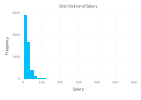

In [7]:
hist_wage = Gadfly.plot(data, x = :wage, Geom.histogram(bincount = 30),
    Guide.xlabel("Salary"), Guide.ylabel("Frequency"), Guide.title("Distribution of Salary"))
display(hist_wage)

## Histogram-Lwage
Log wage per hour

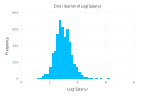

In [8]:
hist_lwage = Gadfly.plot(data, x = :lwage, Geom.histogram(bincount = 30),
    Guide.xlabel("Log(Salary)"), Guide.ylabel("Frequency"), Guide.title("Distribution of Log(Salary)"))
display(hist_lwage)

## Pie-sex
Sex distribution-most of the sample are men, but in a little proportion

In [9]:
stacked_bar_gender = plot(data, x=:sex, color=:sex, Geom.bar(position=:stack),
    Guide.xlabel("Gender"), Guide.ylabel("Count"),
    Guide.title("Distribution of Gender"),
    Theme(panel_fill=colorant"lightblue"),
    Coord.Cartesian(ymin=0))
draw(SVG("stacked_bar_gender.svg", 12cm, 8cm), stacked_bar_gender)

LoadError: UndefVarError: `plot` not defined

## Bar chart-education
In the sample, the biggest goup is on collage

In [10]:
education_counts = combine(groupby(data, [:scl, :clg, :ad]), nrow => :Total)
education_plot = Gadfly.plot(education_counts, x = :Education, y = :Total, color = :Education, 
    Geom.bar(position = :stack), Guide.xlabel("Education Level"), Guide.ylabel("Count"), 
    Guide.title("Distribution of Education Levels"), Theme(axis_text_x = Theme.discrete_label_rotation(45)))
display(education_plot)

LoadError: type DataType has no field discrete_label_rotation

## Scatter plot-exp1-wage

In [11]:
scatterplot_wage = Gadfly.plot(data, x = :exp1, y = :wage, color = :sex,
    Geom.point, Guide.xlabel("Experience (exp1)"), Guide.ylabel("Wage"),
    Guide.title("Scatterplot of Wage by Gender"), Scale.color_manual("",
    ["0" => "blue", "1" => "red"]), Coord.cartesian(), Guide.manual_color_key("Gender", ["Male", "Female"]))
display(scatterplot_wage)

LoadError: UndefVarError: `color_manual` not defined

## Scatter plot-exp1-lwage

In [12]:
scatterplot_lwage = Gadfly.plot(data, x = :exp1, y = :lwage, color = :sex,
    Geom.point, Guide.xlabel("Experience (exp1)"), Guide.ylabel("Log(Wage)"),
    Guide.title("Scatterplot of Log(Wage) by Gender"), Scale.color_manual("",
    ["0" => "blue", "1" => "red"]), Coord.cartesian(), Guide.manual_color_key("Gender", ["Male", "Female"]))
display(scatterplot_wage)

LoadError: UndefVarError: `color_manual` not defined

# ITEM 3

## Confidence interval

In [13]:
ci_b1_lower = b1_est - 1.96 * se1
ci_b1_upper = b1_est + 1.96 * se1
ci_a1_lower = a1_est - 1.96 * se2
ci_a1_upper = a1_est + 1.96 * se2
ci_c1_lower = c1_est - 1.96 * se3
ci_c1_upper = c1_est + 1.96 * se3
conf_intervals_df = DataFrame(
    Model = ["Without Controls", "Full Regression", "Partial Regression"],
    Coef = [b1_est, a1_est, c1_est],
    Lower = [ci_b1_lower, ci_a1_lower, ci_c1_lower],
    Upper = [ci_b1_upper, ci_a1_upper, ci_c1_upper]
)

LoadError: UndefVarError: `se1` not defined

## Graph

In [14]:
conf_plot = Gadfly.plot(conf_intervals_df, x=:Model, y=:Coef, ymin=:Lower, ymax=:Upper,
    Geom.point, Geom.errorbar, Geom.line, Geom.label,
    Guide.xlabel("Model"), Guide.ylabel("Coefficient of sex"),
    Guide.title("Confidence Interval of sex's Coefficient"),
    Theme(axis_text_x = Theme.discrete_label_rotation(45))
)
display(conf_plot)

LoadError: type DataType has no field discrete_label_rotation

# ITEM 4

In [15]:
# Filter clg==1
college_data = filter(row -> row[:clg] == 1, data)

# Graph for female workers
female_college_data = filter(row -> row[:sex] == 1, college_data)
female_plot = Gadfly.plot(female_college_data, x=:exp2, y=:lwage,
    Geom.line(aes(y=:lwage), color="Actual", linetype="Actual"),
    Geom.line(aes(y=:lwage), color="Fitted", linetype="Fitted"), 
    Geom.smooth(method=:lm),
    Guide.xlabel("Experience"), Guide.ylabel("Log(Salary)"),
    Guide.title("Female College-educated Workers"),
    Scale.color_manual("color", ["Actual" => "red", "Fitted" => "blue"]),
    Scale.linetype_manual("linetype", ["Actual" => :solid, "Fitted" => :dashed]),
    Theme(minor_label_font_size=8pt, major_label_font_size=10pt, key_title_font_size=12pt)
)

# Graph for male workers
male_college_data = filter(row -> row[:sex] == 0, college_data)
male_plot = Gadfly.plot(male_college_data, x=:exp2, y=:lwage,
    Geom.line(aes(y=:lwage), color="Actual", linetype="Actual"),
    Geom.line(aes(y=:lwage), color="Fitted", linetype="Fitted"), 
    Geom.smooth(method=:lm),
    Guide.xlabel("Experience"), Guide.ylabel("Log(Salary)"),
    Guide.title("Male College-educated Workers"),
    Scale.color_manual("color", ["Actual" => "green", "Fitted" => "orange"]),
    Scale.linetype_manual("linetype", ["Actual" => :solid, "Fitted" => :dashed]),
    Theme(minor_label_font_size=8pt, major_label_font_size=10pt, key_title_font_size=12pt)
)

# Display the plots
display(female_plot)
display(male_plot)

LoadError: UndefVarError: `aes` not defined